This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn

from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [5]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data

This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [6]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


The predictand tas is **2-D** map - this point is different from the NN case

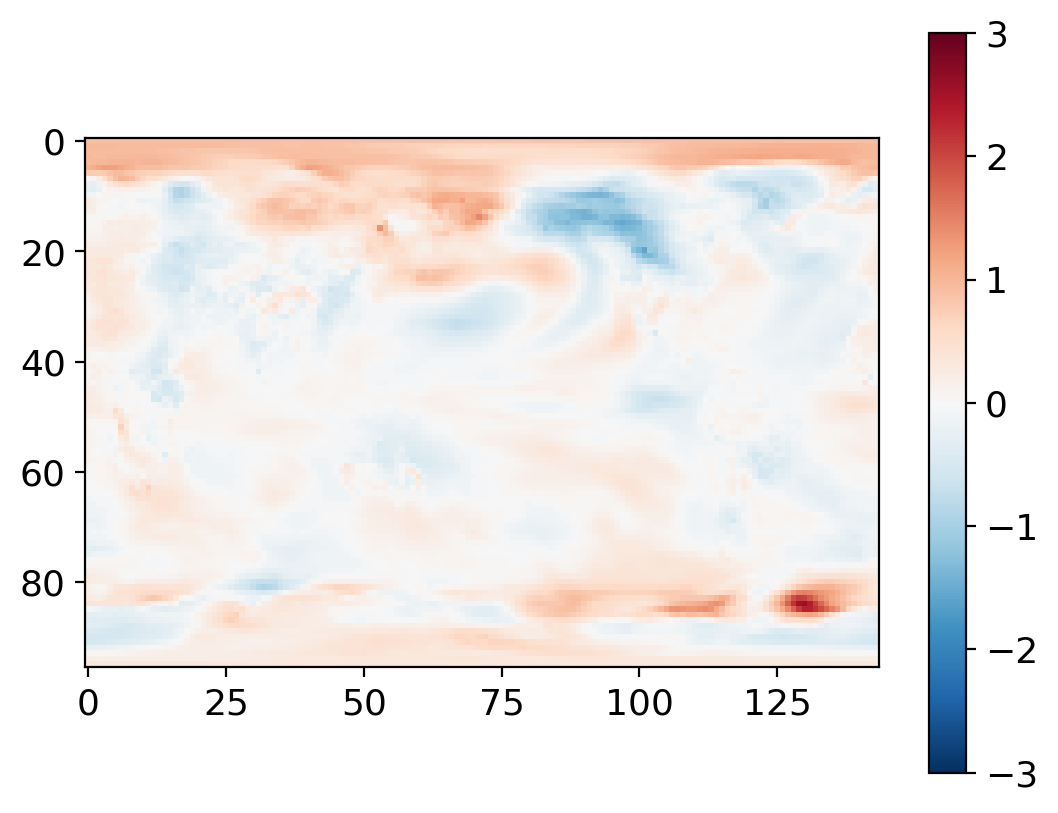

In [7]:
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar()

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [8]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std  #same mean/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

# Convert to PyTorch datasets
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [9]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(753, 2) (753, 96, 144) (86, 2) (86, 96, 144)


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

![image.png](attachment:4547f967-577a-4c0b-8a7f-8e304f6a64bb.png)

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [10]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'ReLU' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [11]:
def make_CNN_model(input_dim, n_filters, activation, kernel_size):
    layers = []
    layers.append(nn.Linear(input_dim, n_filters * 12 * 18))  # shape: (batch_size, 6912) assuming n_filters=32
    layers.append(getattr(nn, activation)())
    
    # custom reshape layer
    class Reshape(nn.Module):
        def __init__(self, shape):
            super().__init__()
            self.shape = shape
        
        def forward(self, x):
            return x.view(-1, *self.shape)
    
    # note that pytorch uses (N,C,H,W)
    layers.append(Reshape((n_filters, 12, 18)))  # shape: (batch_size, 32, 12, 18) 
    
    layers.append(nn.ConvTranspose2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1, output_padding=0))  # shape: (batch_size, 32, 24, 36) - upsampled to 24x36
    layers.append(getattr(nn, activation)())
    layers.append(nn.ConvTranspose2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1, output_padding=0))  # shape: (batch_size, 32, 48, 72) - upsampled to 48x72
    layers.append(getattr(nn, activation)())
    layers.append(nn.ConvTranspose2d(n_filters, n_filters, kernel_size=kernel_size, stride=2, padding=1, output_padding=0))  # shape: (batch_size, 32, 96, 144) - upsampled to 96x144
    layers.append(getattr(nn, activation)())
    # output layer
    layers.append(nn.Conv2d(n_filters, 1, kernel_size=3, padding=1))  # shape: (batch_size, 1, 96, 144) - final output
    
    return nn.Sequential(*layers)

In [12]:
model_mse = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

In [13]:
print("Model:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters())}")

Model:
Sequential(
  (0): Linear(in_features=2, out_features=6912, bias=True)
  (1): ReLU()
  (2): Reshape()
  (3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Total parameters: 70273


### 3. Train & save the CNN model

In [14]:
def pytorch_train(model, optimizer, criterion, device):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
       # training
       model.train()
       train_loss = 0.0
       for batch_X, batch_y in train_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           # forward pass
           optimizer.zero_grad()
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           # backward pass
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
    
        # validation
       model.eval()
       val_loss = 0.0
       with torch.no_grad():
           for batch_X, batch_y in val_loader:
               batch_X = batch_X.to(device)
               batch_y = batch_y.to(device)
               
               outputs = model(batch_X)
               loss = criterion(outputs, batch_y)
               val_loss += loss.item()
       
       train_loss /= len(train_loader)
       val_loss /= len(val_loader)
    
       train_losses.append(train_loss)
       val_losses.append(val_loss)
       
       print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
       
       if val_loss < best_val_loss:
           best_val_loss = val_loss
           patience_counter = 0
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print(f'Early stopping at epoch {epoch+1}')
               break
   
    return train_losses, val_losses

In [15]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [16]:
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)
# Loss function
mse_loss = nn.MSELoss()

In [17]:
train_losses_mse, val_losses_mse = pytorch_train(model_mse.to(device), optimizer_mse, criterion = mse_loss, device = device)

Epoch 1/100, Train Loss: 2.9914, Val Loss: 2.2116
Epoch 2/100, Train Loss: 2.1196, Val Loss: 2.0422
Epoch 3/100, Train Loss: 1.9943, Val Loss: 1.8217
Epoch 4/100, Train Loss: 1.7235, Val Loss: 1.6188
Epoch 5/100, Train Loss: 1.5272, Val Loss: 1.3724
Epoch 6/100, Train Loss: 1.2078, Val Loss: 1.0730
Epoch 7/100, Train Loss: 0.9363, Val Loss: 0.9153
Epoch 8/100, Train Loss: 0.7837, Val Loss: 0.7972
Epoch 9/100, Train Loss: 0.7018, Val Loss: 0.7085
Epoch 10/100, Train Loss: 0.6482, Val Loss: 0.6577
Epoch 11/100, Train Loss: 0.6164, Val Loss: 0.6501
Epoch 12/100, Train Loss: 0.5761, Val Loss: 0.5924
Epoch 13/100, Train Loss: 0.5430, Val Loss: 0.5624
Epoch 14/100, Train Loss: 0.5219, Val Loss: 0.5405
Epoch 15/100, Train Loss: 0.4965, Val Loss: 0.5212
Epoch 16/100, Train Loss: 0.4853, Val Loss: 0.5060
Epoch 17/100, Train Loss: 0.4771, Val Loss: 0.4878
Epoch 18/100, Train Loss: 0.4601, Val Loss: 0.4739
Epoch 19/100, Train Loss: 0.4530, Val Loss: 0.4763
Epoch 20/100, Train Loss: 0.4499, Val Lo

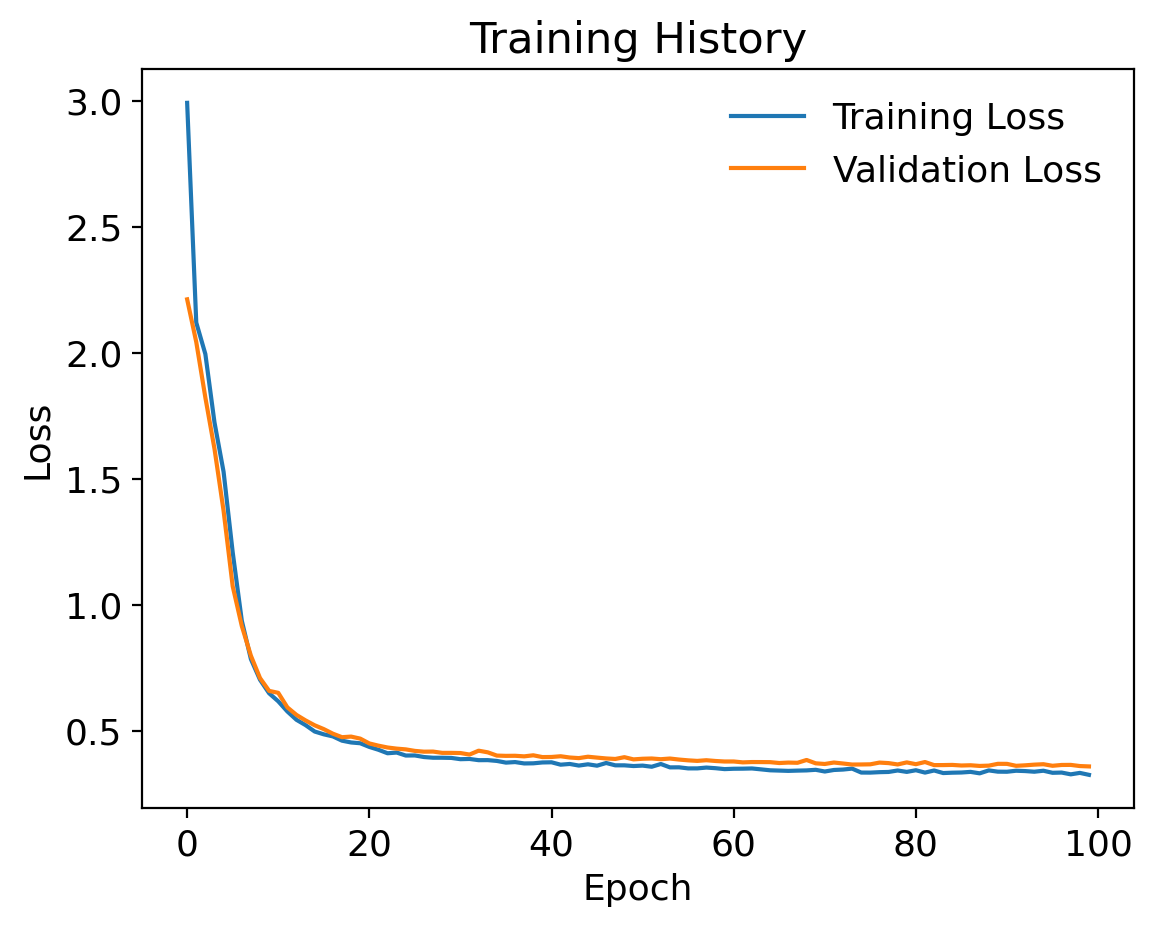

In [18]:
plot_history(train_losses_mse, val_losses_mse)

In [20]:
model_mae = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)
# L1Loss = MAE
mae_loss = nn.L1Loss(reduction='mean') 
optimizer_mae = torch.optim.Adam(model_mae.parameters(), lr=learning_rate)
train_losses_mae, val_losses_mae = pytorch_train(model_mae.to(device), optimizer_mae, criterion = mae_loss, device = device)

Epoch 1/100, Train Loss: 0.9819, Val Loss: 0.9212
Epoch 2/100, Train Loss: 0.9320, Val Loss: 0.9089
Epoch 3/100, Train Loss: 0.8917, Val Loss: 0.8680
Epoch 4/100, Train Loss: 0.8393, Val Loss: 0.8126
Epoch 5/100, Train Loss: 0.7602, Val Loss: 0.7693
Epoch 6/100, Train Loss: 0.6986, Val Loss: 0.7087
Epoch 7/100, Train Loss: 0.6380, Val Loss: 0.6357
Epoch 8/100, Train Loss: 0.5884, Val Loss: 0.5845
Epoch 9/100, Train Loss: 0.5527, Val Loss: 0.5531
Epoch 10/100, Train Loss: 0.5268, Val Loss: 0.5321
Epoch 11/100, Train Loss: 0.5139, Val Loss: 0.5151
Epoch 12/100, Train Loss: 0.4943, Val Loss: 0.4992
Epoch 13/100, Train Loss: 0.4854, Val Loss: 0.4896
Epoch 14/100, Train Loss: 0.4750, Val Loss: 0.4794
Epoch 15/100, Train Loss: 0.4662, Val Loss: 0.4724
Epoch 16/100, Train Loss: 0.4625, Val Loss: 0.4663
Epoch 17/100, Train Loss: 0.4559, Val Loss: 0.4632
Epoch 18/100, Train Loss: 0.4509, Val Loss: 0.4574
Epoch 19/100, Train Loss: 0.4443, Val Loss: 0.4531
Epoch 20/100, Train Loss: 0.4482, Val Lo

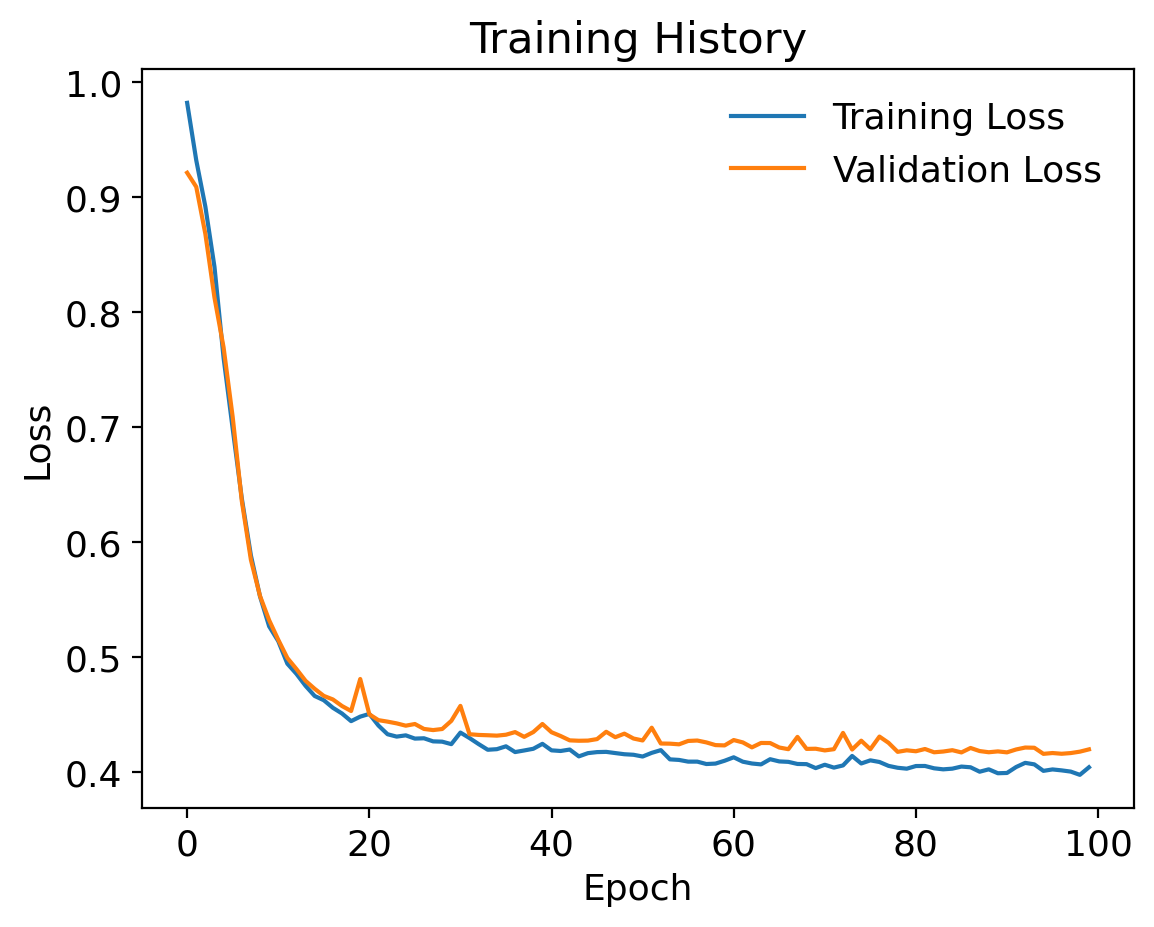

In [21]:
plot_history(train_losses_mae, val_losses_mae)

In [22]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [23]:
# Save the model  weightsto a pth file.
torch.save(model_mse.state_dict(), os.path.join(model_path,'CNN_model_mse_weights.pth'))
torch.save(model_mae.state_dict(), os.path.join(model_path,'CNN_model_mae_weights.pth'))

### 4. Evaluate the trained model

In [24]:
# make new model instances for evaluation (best practice)
model_mse_eval = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)
model_mae_eval = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

# reload the saved model weights
state_dict_mse = torch.load(os.path.join(model_path,'CNN_model_mse_weights.pth'), weights_only=True)
model_mse_eval.load_state_dict(state_dict_mse)

state_dict_mae = torch.load(os.path.join(model_path,'CNN_model_mae_weights.pth'), weights_only=True)
model_mae_eval.load_state_dict(state_dict_mae)

<All keys matched successfully>

In [25]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model_mse_eval.to(device).eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model_mse_eval(batch_X)
       predictions.append(outputs.cpu().numpy())

y_test_mse_pre = np.concatenate(predictions, axis=0)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 96, 144)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                              'latitude': X_test_xr.latitude.values, 
                              'longitude': X_test_xr.longitude.values},
                      data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

model_mae_eval.to(device).eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model_mae_eval(batch_X)
       predictions.append(outputs.cpu().numpy())

y_test_mae_pre = np.concatenate(predictions, axis=0)
y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 96, 144)
y_test_mae_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                              'latitude': X_test_xr.latitude.values, 
                              'longitude': X_test_xr.longitude.values},
                      data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mae_pre)))

First we check whether the ML model can capture the spatial distribution of global temperature

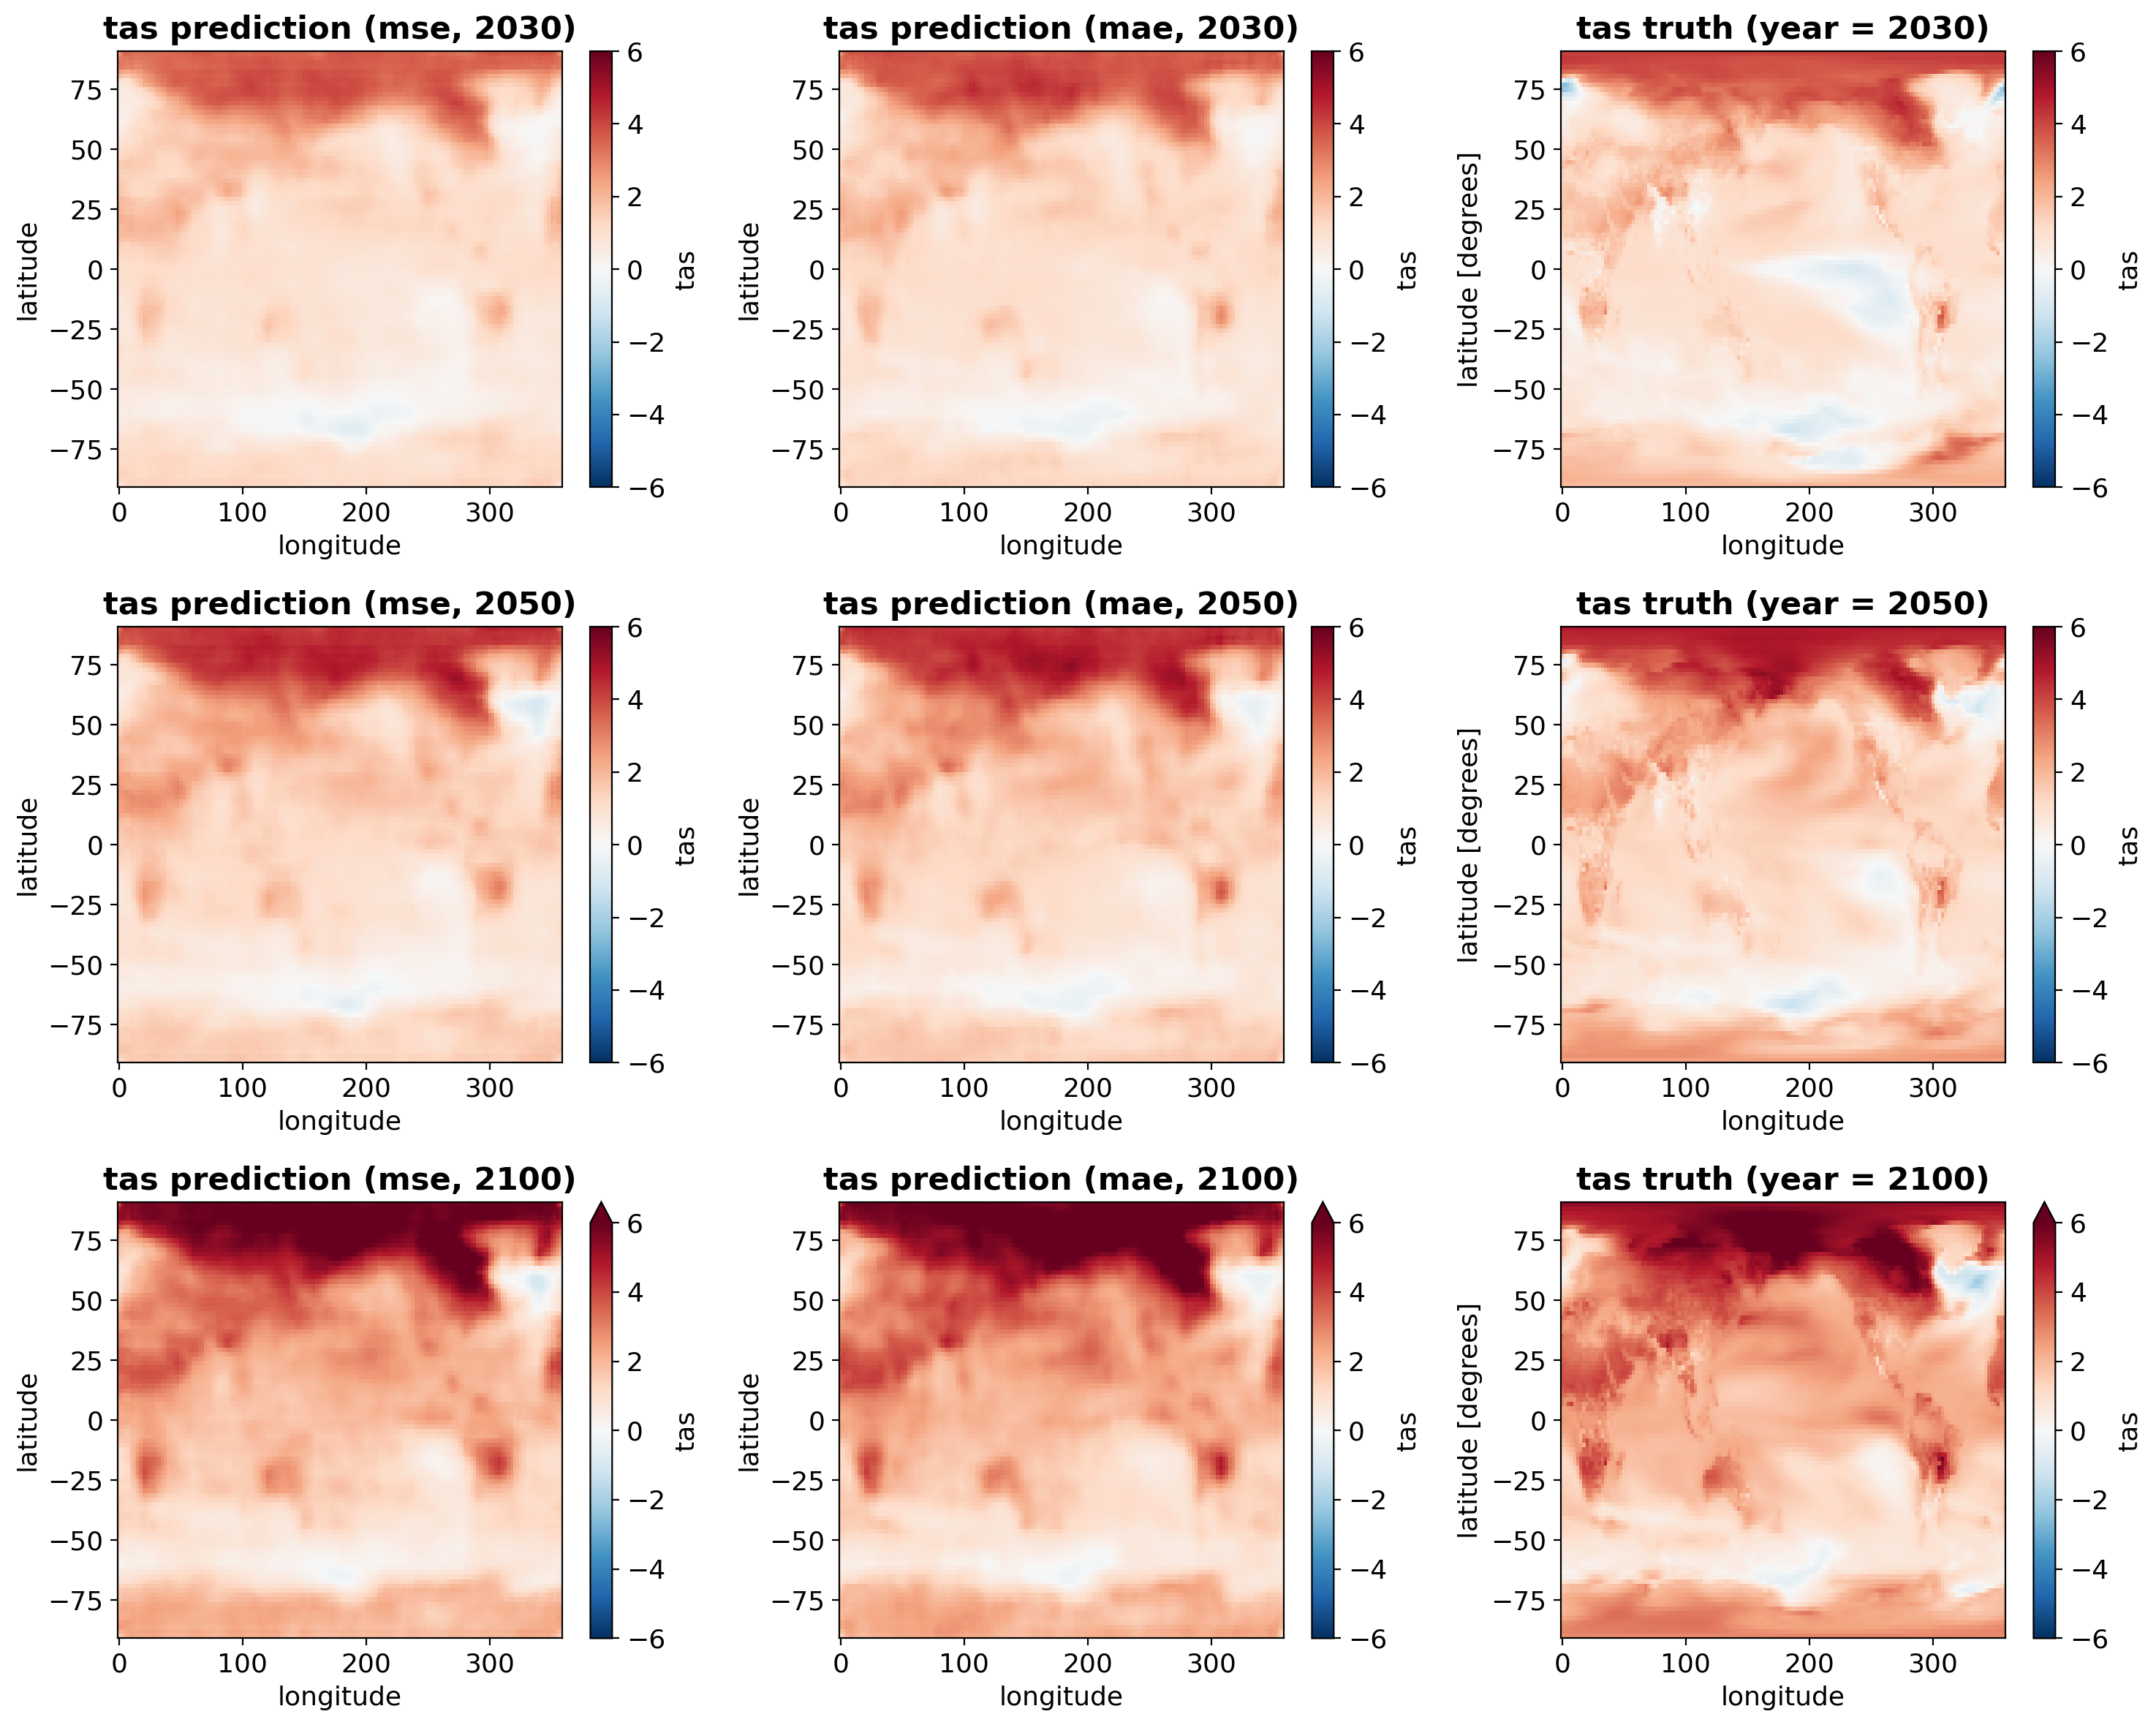

In [26]:
fig, axes = plt.subplots(figsize=(15,12),ncols=3,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_mse_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,2], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 3 == 0:
        ax.set_title(f'tas prediction (mse, {yrs[i//3]})',fontweight='bold')
    # middle column: model prediction
    elif i % 3 == 1:
        ax.set_title(f'tas prediction (mae, {yrs[i//3]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//3]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

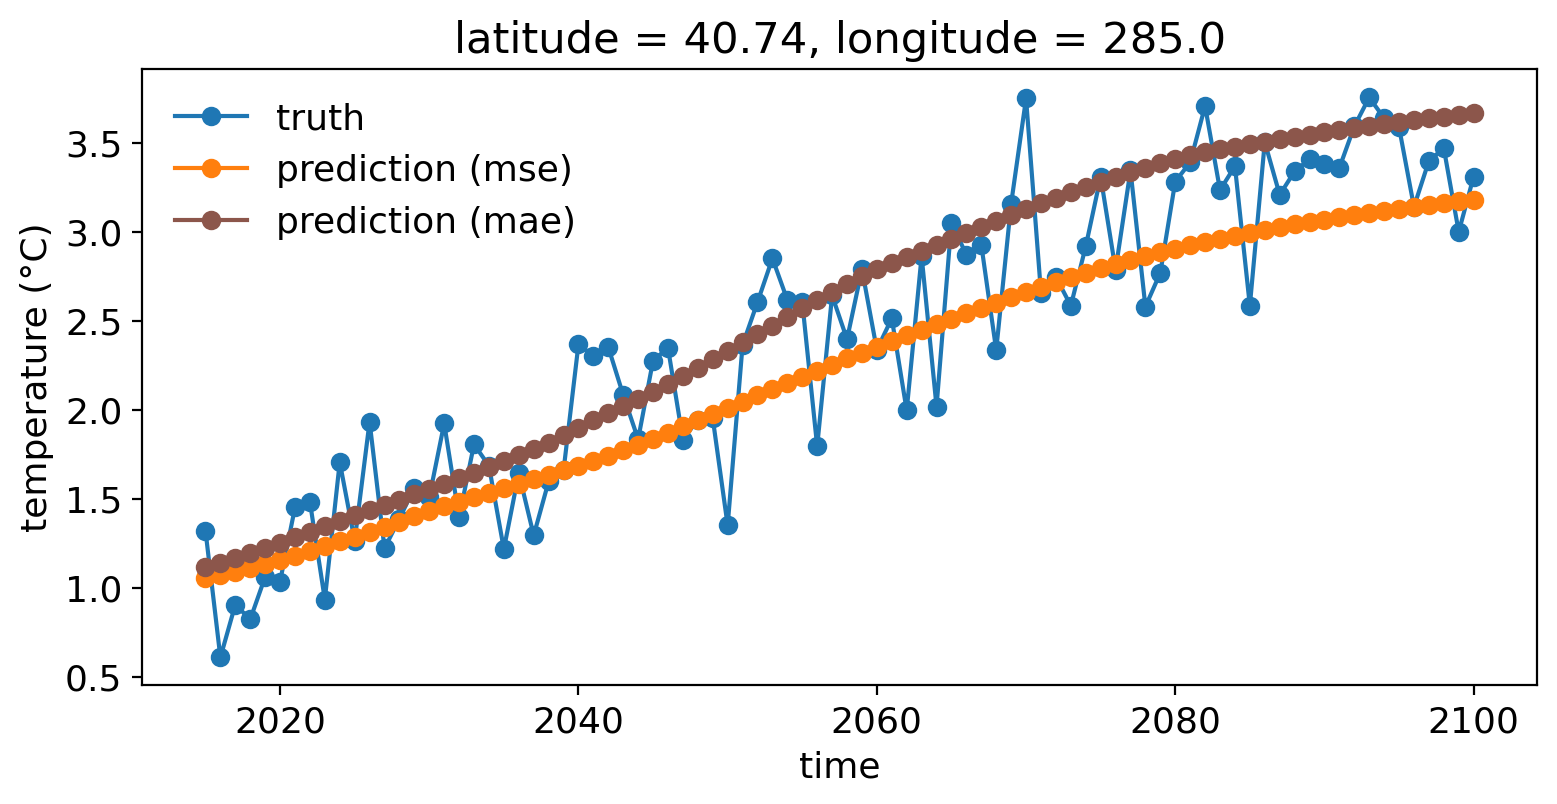

In [27]:
#NY
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction (mse)')
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('NYC temperature (°C)')

Text(0, 0.5, 'Amazon temperature (°C)')

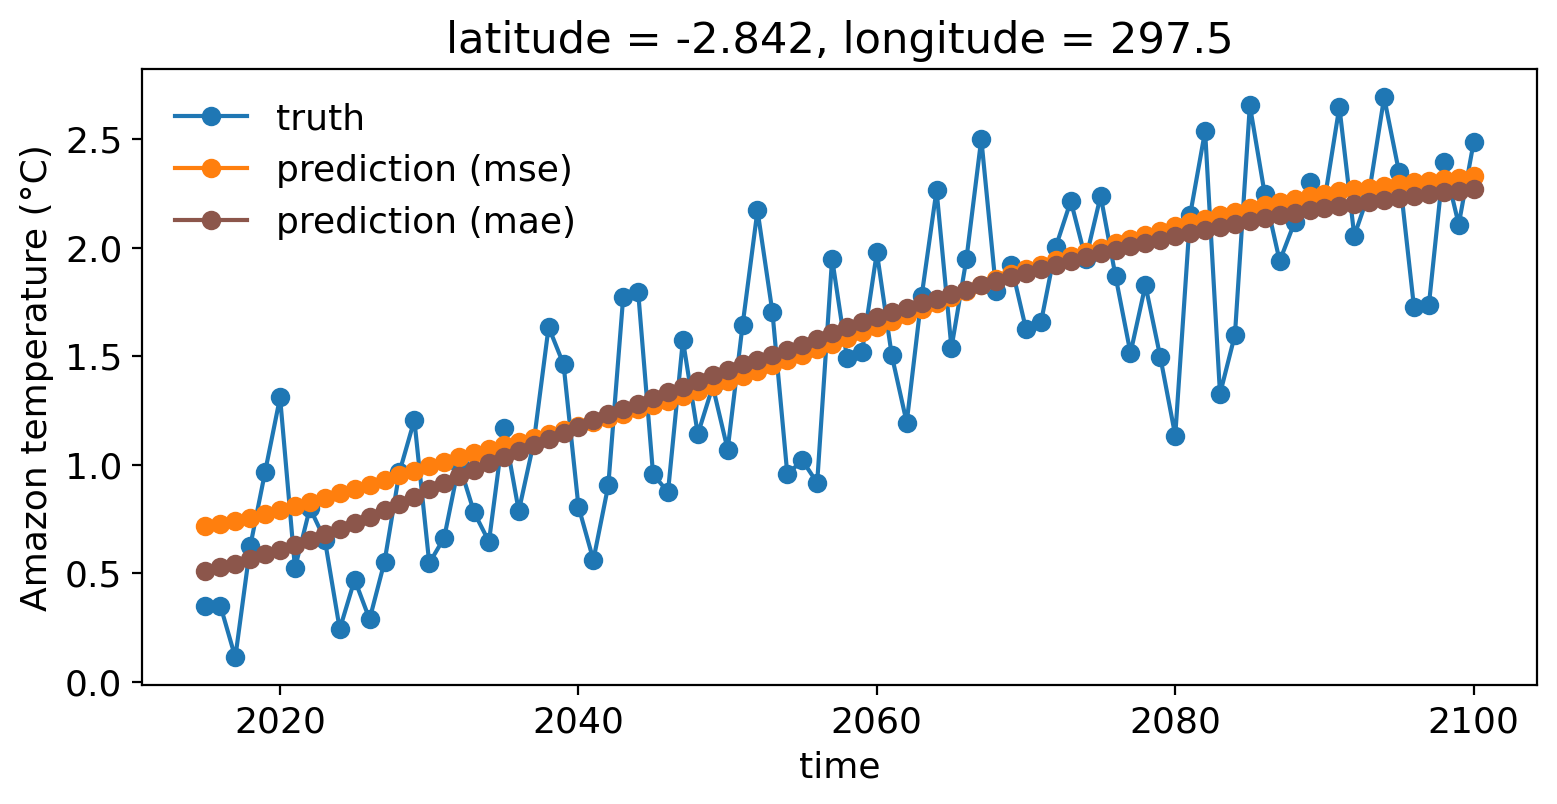

In [28]:
#Amazon
lat = -3.4653
lon = -62.2159%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction (mse)')
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('Amazon temperature (°C)')

In [31]:
y_test_xr_amazon=y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values

In [32]:
y_test_mse_pre_amazon=y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test_xr_amazon, y_test_mse_pre_amazon))
print(rmse)

0.37952235362594805


Text(0, 0.5, 'Sahara temperature (°C)')

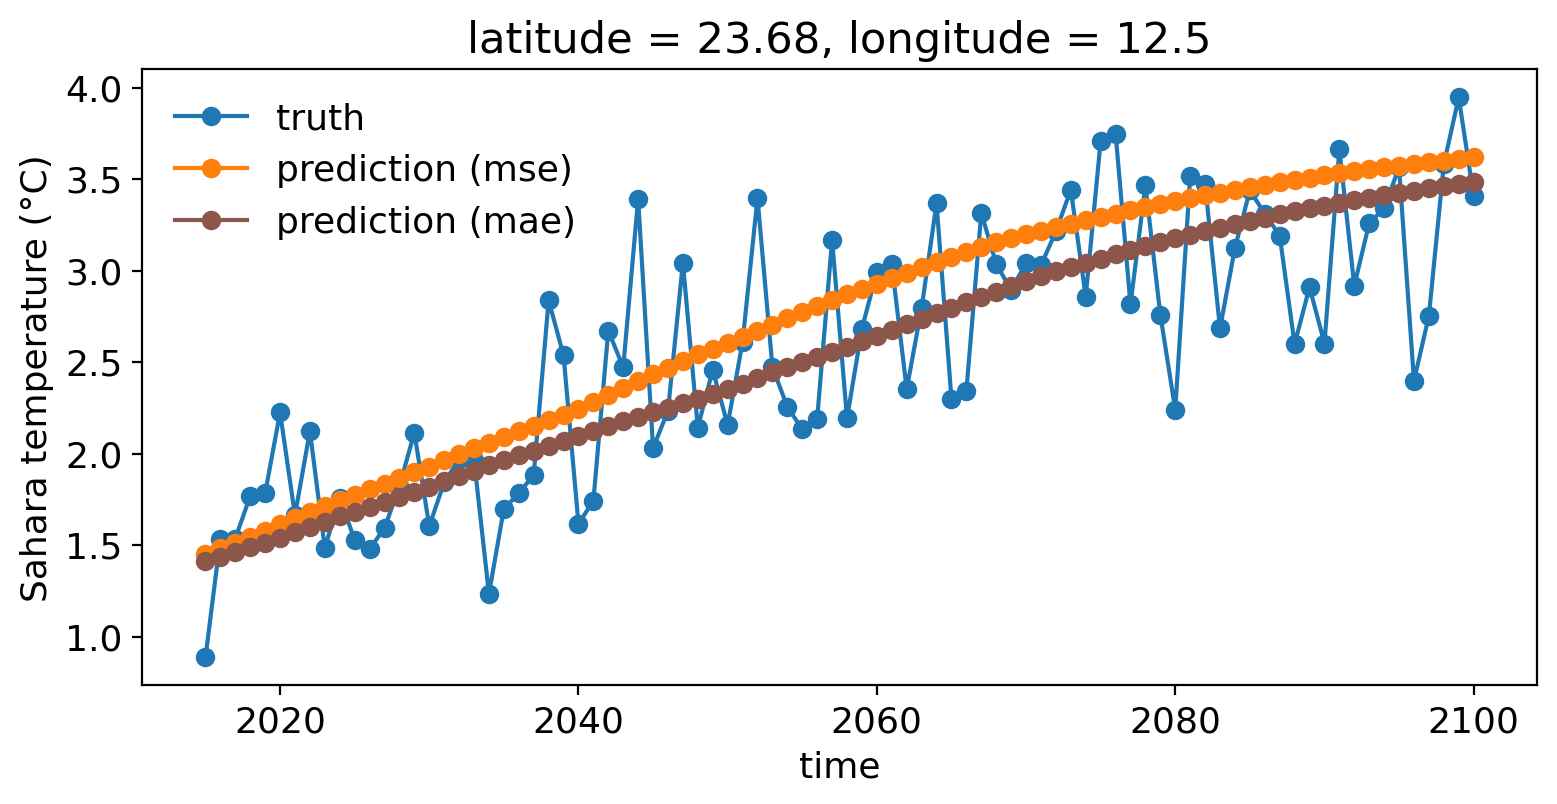

In [35]:
#Sahara
lat = 23.8063
lon = 11.7915%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction (mse)')
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('Sahara temperature (°C)')

In [36]:
y_test_xr_sahara=y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values

In [37]:
y_test_mse_pre_sahara=y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test_xr_sahara, y_test_mse_pre_sahara))
print(rmse)

0.45698185189145657


Let's check the statistical comparison between truth and prediction.

In [28]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_mse"] = nyc_test_mse_pre
df_nyc_test["prediction_mae"] = nyc_test_mae_pre
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction_mse  prediction_mae
0  2015  1.321960        1.053082        1.117076
1  2016  0.608693        1.071751        1.142046
2  2017  0.905599        1.091349        1.167542
3  2018  0.822795        1.111980        1.193352
4  2019  1.061228        1.132917        1.222086
5  2020  1.035349        1.155555        1.252937
6  2021  1.451701        1.181576        1.283742
7  2022  1.484253        1.208041        1.314691
8  2023  0.934296        1.235169        1.346000
9  2024  1.707011        1.261089        1.378058


,time,truth,prediction_mse,prediction_mae
count,86.000000,86.000000,86.000000,86.000000
mean,2057.500000,2.395548,2.217079,2.555852
std,24.969982,0.836997,0.691993,0.847001
min,2015.000000,0.608693,1.053082,1.117076
25%,2036.250000,1.691455,1.591320,1.753194
50%,2057.500000,2.456390,2.272206,2.688135
75%,2078.750000,3.155296,2.881034,3.381821
max,2100.000000,3.757050,3.181919,3.668950


Finally we check whether the ML model can capture the time series of global average temperature 

In [29]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

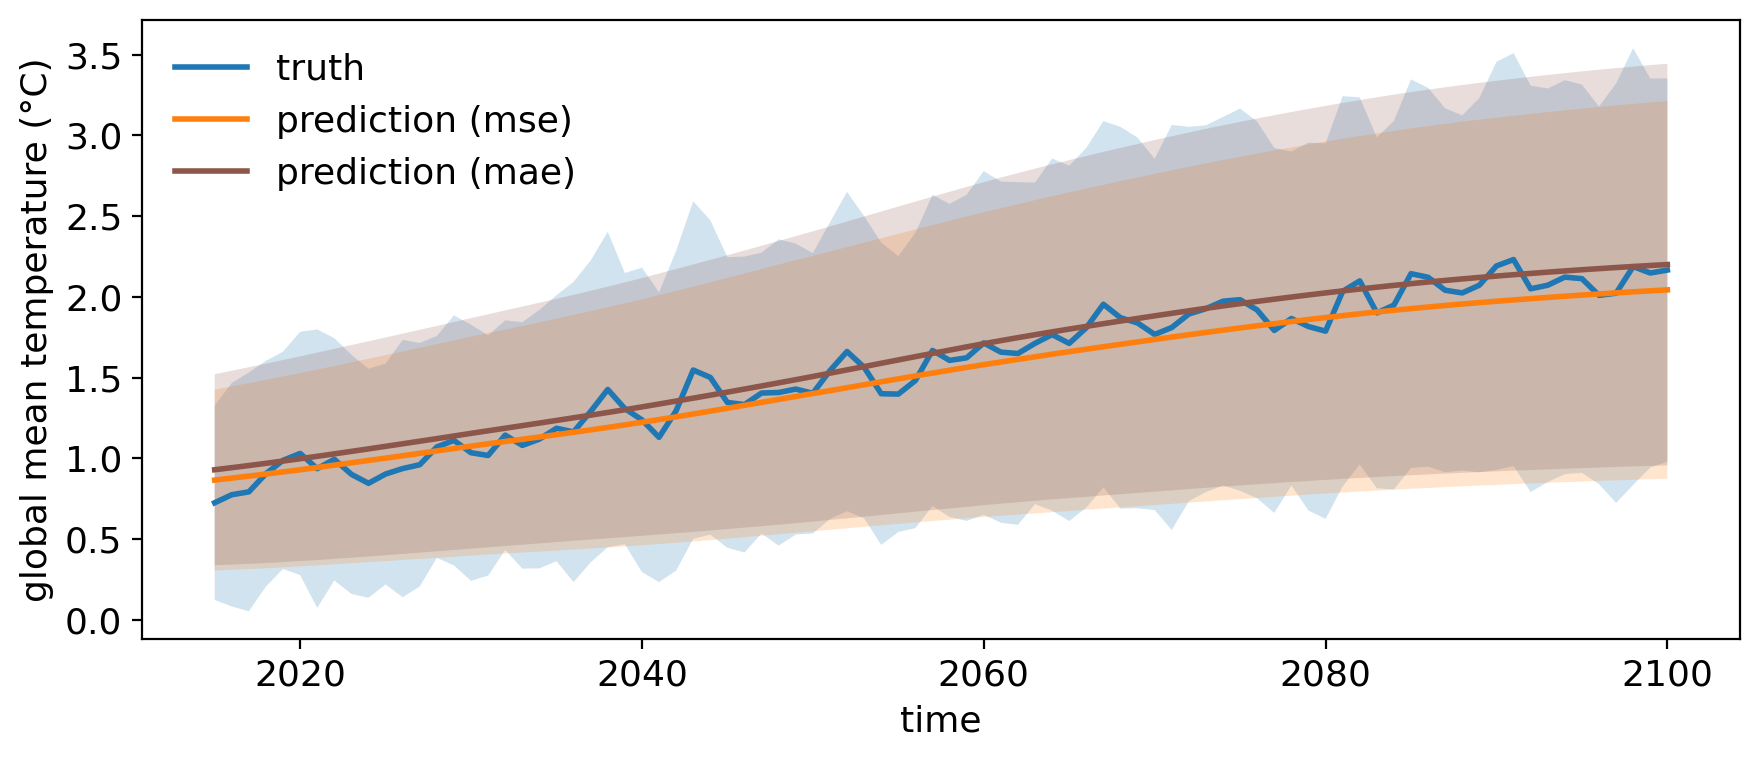

In [30]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='prediction (mse)',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_mae_pre,label='prediction (mae)',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [31]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_mse_pre = global_mean(y_test_mse_pre)
tas_mean_mae_pre = global_mean(y_test_mae_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction_mse"] = tas_mean_mse_pre
df_globalmean_test["prediction_mae"] = tas_mean_mae_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction_mse  prediction_mae
0  2015  0.724876        0.865017        0.929308
1  2016  0.774634        0.877463        0.942134
2  2017  0.792321        0.889993        0.955350
3  2018  0.905029        0.902771        0.969008
4  2019  0.987700        0.915784        0.983100
5  2020  1.030206        0.929098        0.997477
6  2021  0.935918        0.943295        1.012517
7  2022  0.994084        0.957739        1.027710
8  2023  0.900831        0.972308        1.042986
9  2024  0.845252        0.986839        1.058473


,time,truth,prediction_mse,prediction_mae
count,86.000000,86.000000,86.000000,86.000000
mean,2057.500000,1.564246,1.505340,1.624265
std,24.969982,0.430099,0.375608,0.408377
min,2015.000000,0.724876,0.865017,0.929308
25%,2036.250000,1.169074,1.164991,1.255073
50%,2057.500000,1.635698,1.536706,1.659889
75%,2078.750000,1.943204,1.856291,2.008456
max,2100.000000,2.230782,2.043108,2.199920
